# Introducción al problema de robustez

In [ ]:
# Imports de librerías
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch 
from torch import nn
import torchvision
from torch.nn import functional as F
import time
from torchvision.models import resnet50
import json
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-10-20 18:52:19--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-10-20 18:52:20 (63.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



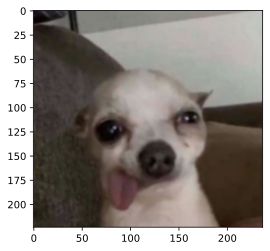

In [ ]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
chihuahua_img = Image.open("chihua2.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
chihuahua_tensor = preprocess(chihuahua_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(chihuahua_tensor[0].numpy().transpose(1,2,0))

In [ ]:
# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [ ]:
# form predictions
pred = model(norm(chihuahua_tensor))

In [ ]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

Chihuahua


### ¿Cómo manipulamos esta imagen para que el clasificador crea que es otra cosa?

#### El término clave de interés aquí es el gradiente de la función de pérdida, que calcula cómo un pequeño ajuste a cada uno de los parámetros afectará la función de pérdida

In [ ]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(chihuahua_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(chihuahua_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -11.219718933105469
5 -25.165246963500977
10 -24.62956428527832
15 -23.736732482910156
20 -31.47397232055664
25 -32.05107879638672
True class probability: 4.3756475328537916e-16


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  Italian_greyhound
Predicted probability: 0.9999426603317261


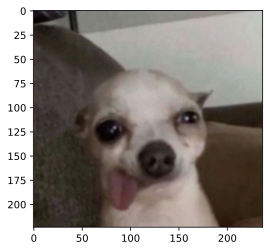

In [ ]:
plt.imshow((chihuahua_tensor + delta)[0].detach().numpy().transpose(1,2,0))

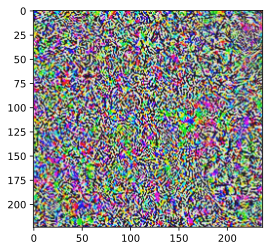

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

## Ataque dirigido

In [ ]:
delta = torch.zeros_like(chihuahua_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(chihuahua_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([934])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 0.21442794799804688
10 -21.764307022094727
20 -46.629451751708984
30 -60.89358139038086
40 -60.9024772644043
50 -72.32357788085938
60 -76.4844741821289
70 -77.84639739990234
80 -74.00577545166016
90 -71.0068588256836


In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  hotdog
Predicted probability: 1.0


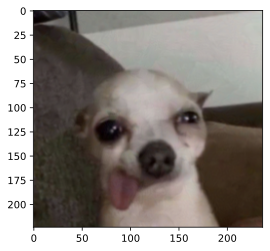

In [ ]:
plt.imshow((chihuahua_tensor + delta)[0].detach().numpy().transpose(1,2,0))

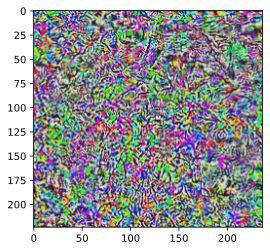

In [ ]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

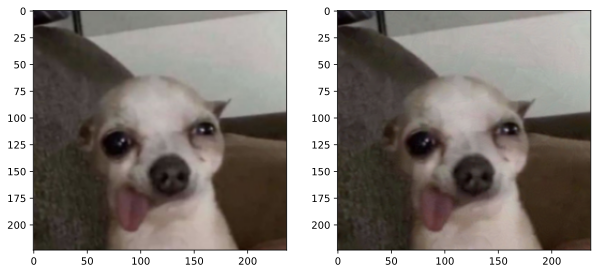

In [ ]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

# Ejemplos contradictorios aplicados a clasificación multiclase

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Net(nn.Module): # Red neuronal convolucional de LeNet [1]
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
pretrained_model = "data/lenet_mnist_model.pth"

In [ ]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def pgd(modelo, X, y, epsilon, alpha, num_iter):
    """ Construct PGD adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(modelo(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach(), loss.item()

In [ ]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [ ]:
def accuracy(y,yp):
  correct = 0
  for i in range(len(y)):
    if yp[i].max(dim=0)[1] == y[i]:
      correct +=1
  return correct/len(y)

In [ ]:
def plot_images(X,y,yp,M,N):
  f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
  for i in range(M):
      for j in range(N):
          ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
          title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
          plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
          ax[i][j].set_axis_off()
  plt.tight_layout()

### Primero veamos algunas de las muestras que generamos con este método en el modelo

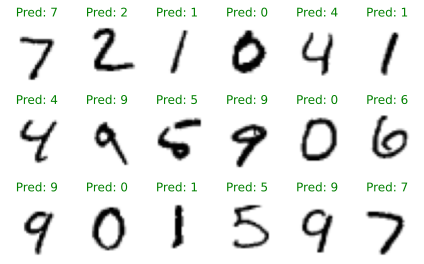

In [ ]:
### Illustrate original predictions
yp = model(X)
plot_images(X, y, yp, 3, 6)

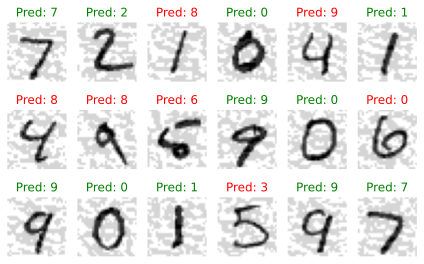

In [ ]:
### Illustrate attacked images
delta = pgd(model, X, y, 0.1, 1e4, 1000)[0]
yp = model(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
def calculate_acc_loss(model, iterator, eps, alpha = 1e4, num_iter=1000):
  for X,y in iterator:
    X,y = X.to(device), y.to(device)
    break
  delta = pgd(model, X, y, eps, alpha, num_iter)[0]
  yp = model(X + delta)
  acc = accuracy(y, yp)
  loss = pgd(model, X, y, eps, alpha, num_iter)[1]
  print("Epsilon: {}\tTest Accuracy = {}\tloss = {}".format(eps, acc, loss))

In [ ]:
calculate_acc_loss(model, test_loader, 0.1, 1e4)

Epsilon: 0.1	Test Accuracy = 0.61	loss = 1.319926142692566


In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []
filtro = []

for eps in epsilons:
  calculate_acc_loss(model, test_loader, eps)

Epsilon: 0	Test Accuracy = 0.99	loss = 0.24424566328525543
Epsilon: 0.05	Test Accuracy = 0.91	loss = 0.6418419480323792
Epsilon: 0.1	Test Accuracy = 0.61	loss = 1.319926142692566
Epsilon: 0.15	Test Accuracy = 0.23	loss = 2.0429162979125977
Epsilon: 0.2	Test Accuracy = 0.04	loss = 2.720762252807617
Epsilon: 0.25	Test Accuracy = 0.04	loss = 3.186458110809326
Epsilon: 0.3	Test Accuracy = 0.02	loss = 3.7185988426208496
